In [1]:
# Generic imports
import clr
import sys
import os
from System.IO import *
from System import String
from System.Collections.Generic import List
#clr.AddReference('System.IO')
#clr.AddReference('System.Collections')

# Needed dll for interaction with LF
sys.path.append(os.environ['LIGHTFIELD_ROOT'])
sys.path.append(os.environ['LIGHTFIELD_ROOT']+'\\AddInViews')
clr.AddReference('PrincetonInstruments.LightFieldViewV5')
clr.AddReference('PrincetonInstruments.LightField.AutomationV5')
clr.AddReference('PrincetonInstruments.LightFieldAddInSupportServices')

# PI imports
#clr.AddReference('PrincetonInstruments.LightField')
#clr.AddReference('PrincetonInstruments.LightField.Automation')
import PrincetonInstruments.LightField.AddIns as AddIns
from PrincetonInstruments.LightField.Automation import Automation
from PrincetonInstruments.LightField.AddIns import CameraSettings
from PrincetonInstruments.LightField.AddIns import DeviceType
from PrincetonInstruments.LightField.AddIns import ExperimentSettings

class LightField:
    def __init__(self):
        self.auto = Automation(True, List[String]())
        self.experiment = self.auto.LightFieldApplication.Experiment
        for device in experiment.ExperimentDevices:
            if device.Type == DeviceType.Camera:
                print("Device setup OK")
                
    def set_value(self, setting, value):
        if self.experiment.Exists(setting):
            self.experiment.SetValue(setting, value)
    
    def set_acquisition_time(self, acq_t):
        self.set_value(CameraSettings.ShutterTimingExposureTime, acq_t*1000) #ms

    def set_path(self, directory):
        self.set_value(ExperimentSettings.FileNameGenerationDirectory, directory)
    
    def set_filename(self, name):
        self.set_value(ExperimentSettings.FileNameGenerationBaseFileName, name)
    
    def set_filename_increment(self, num_incr=False, date_incr=False, time_incr=False):
        self.set_value(ExperimentSettings.FileNameGenerationAttachIncrement, num_incr)
        self.set_value(ExperimentSettings.FileNameGenerationAttachDate, date_incr)
        self.set_value(ExperimentSettings.FileNameGenerationAttachTime, time_incr)
        
    def acquire(self):
        while not self.experiment.IsReadyToRun:
            time.sleep(.1)
        self.experiment.Acquire()
        while self.experiment.IsRunning:
            time.sleep(.1)
            
    def load_acquired_data(self, directory, filename):
        while not os.path.exists(directory + "\\" + filename + ".spe"):
            time.sleep(.1)
        while True:
            try:
                return Spectrum(directory + "\\" + filename + ".spe")
            except PermissionError:
                time.sleep(.1)

LFauto = LightField()

c:\users\spectroscopist\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: The module was found, but not in a referenced namespace.
Implicit loading is deprecated. Please use clr.AddReference('System.IO').
  """
c:\users\spectroscopist\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: The module was found, but not in a referenced namespace.
Implicit loading is deprecated. Please use clr.AddReference('System.Collections').
  import sys
c:\users\spectroscopist\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The module was found, but not in a referenced namespace.
Implicit loading is deprecated. Please use clr.AddReference('PrincetonInstruments.LightField').
c:\users\spectroscopist\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: The module was found, but not in a referenced names

In [2]:
# SPE file plotting related
import time
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.append("..")
from LowLevelModules.Spectroscopy import Spectrum
from LowLevelModules.GeneralFunctions import prettify_2d_plot

Keithley stuff

In [3]:
from pymeasure.instruments.keithley import Keithley2400
keithley = Keithley2400("GPIB0::24::INSTR")   # 'ASRL9::INSTR' if RS232 connection
keithley.apply_voltage()                      # Sets up to source voltage
keithley.source_voltage_range = 20            # Sets the source voltage range to 1 V
keithley.compliance_current = 5e-5            # Sets the compliance current to 1 mA
keithley.source_voltage = 0                   # Sets the source current to 0 mA
keithley.measure_voltage()                    # Sets up to measure voltage

In [5]:
import ipywidgets as widgets
from IPython.display import display

etaloning_choice = widgets.Checkbox(value=False, description='Remove CCD etaloning')
x_axis_choice = widgets.RadioButtons(options=['Wavelength (nm)', 'Energy (eV)'],
                                     value='Wavelength (nm)',
                                     description='X axis unit:')
display(etaloning_choice)
display(x_axis_choice)
#add box for base name
#add box for working dir
#add voltage range

Checkbox(value=False, description='Remove CCD etaloning')

RadioButtons(description='X axis unit:', options=('Wavelength (nm)', 'Energy (eV)'), value='Wavelength (nm)')

In [113]:
class LivePlot2D:
    def __init__(self, x_data, y_data, z_data, x_ext=18, y_ext=6, mk='o'):
        self.fig = plt.figure(figsize=(x_ext, y_ext))
        self.ax = self.fig.add_subplot(111)
        self.extent = [np.min(x_data), np.max(x_data), np.min(y_data), np.max(y_data)]
        self.fig.show()
        self.cp = self.ax.imshow(z_data, cmap='jet', origin='center', extent=self.extent, 
                       interpolation='nearest', vmin=0, vmax=np.max(z_data), aspect=8)

        self.cb = self.fig.colorbar(self.cp, fraction=0.046, pad=0.04)
        self.fig.canvas.draw()
        #self.fig.tight_layout()

    def plot_live(self, z_data):
                
        self.ax.imshow(z_data, cmap='jet', origin='center', extent=self.extent, 
                       interpolation='nearest', vmin=0, vmax=np.max(z_data), aspect=8)
        self.fig.canvas.draw()
        plt.pause(1e-6)

Acquisition done.


<IPython.core.display.Javascript object>


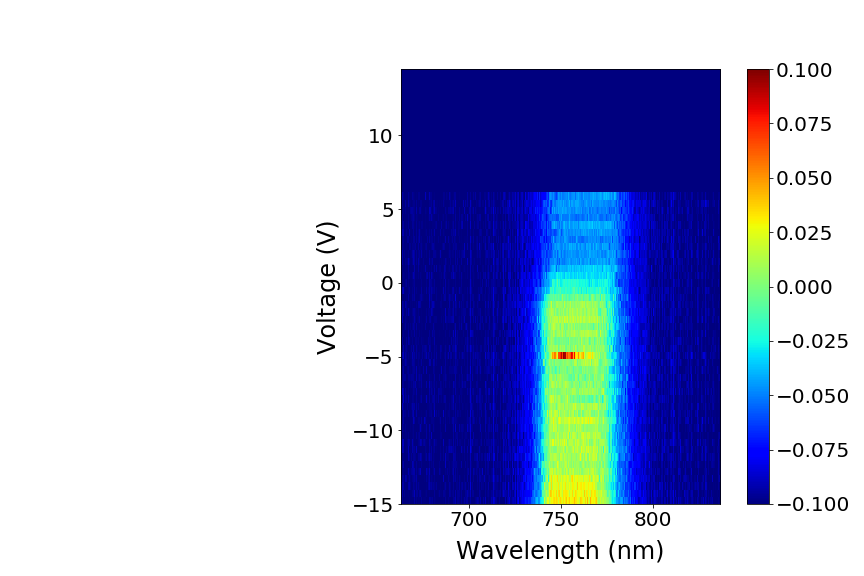

KeyboardInterrupt: 

In [114]:
wdir = r'Z:\Projects\WSe2\2019\03 march\Automation tryouts'
V_range = np.arange(-15,15,.5)
# Enable the voltage source output
keithley.enable_source()
#deal with LightField settings
LFauto.set_acquisition_time(2)
LFauto.set_path(wdir)
LFauto.set_filename("ref_spect_noV")
LFauto.set_filename_increment()

# Acquire image in LightField
LF_auto.acquire()
data_ref = LF_auto.load_acquired_data(wdir, "ref_spect_noV")

#initialize the data
xdata = data_ref.x
ydata = V_range
zdata = np.zeros((len(ydata), len(xdata)))

lp = LivePlot2D(xdata, ydata, zdata, 12, 8, 'o')
prettify_2d_plot(lp.ax, lp.cb, x_axis_choice.value, 'Voltage (V)', 'Count rate (Hz)')

base_name = "WSe2_hBN_graphene_RT_532nmexc_2uW_"
for i, v in enumerate(V_range):
    # change the voltage
    keithley.ramp_to_voltage(v)
    # update file name to save data
    LFauto.set_filename(base_name + str(v) + "V")
    # Acquire image
    LF_auto.acquire()
    data = LF_auto.load_acquired_data(wdir, "ref_spect_noV")
    data.remove_cosmic_ray(2)
#     if etaloning_choice.value:
#         data.remove_etaloning(0.30, 0.46, 0.02, plotplot=False)
#     if x_axis_choice.value == 'Energy (eV)':
#         data.x = 1241/data.x
#         data.x = data.x[::-1]
#         data.y = data.y[::-1]
#     if normalize_choice.value:
#         data.y = data.y / np.max(data.y) + i*0.5
    
    zdata[i,:] = data.y
    lp.plot_live(zdata)  
    
keithley.ramp_to_voltage(0)
keithley.disable_source()